In [16]:
import os
import abc
import time
import typing
import random
import warnings

import tqdm
import torch
import wandb
import numpy
import pandas
import torchscan
import torchvision
import sklearn.metrics
import matplotlib.pyplot as plt
import torch.utils.data as torchdata
from torchvision.transforms import v2 as transforms

device = torch.device(
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)
print(device)

RANDOM_STATE = 42
def set_random_seed(seed):
    random.seed(seed)
    numpy.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.backends.cudnn.deterministic = True
def fix_random():
    return set_random_seed(RANDOM_STATE)
fix_random()

cuda


In [17]:
wandb.login(anonymous = "allow")

True

# Show base model

Load resnet model form pytorch model zoo

In [18]:
torchvision.models.resnet18()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Load the dataset

Load and preprocess the data.
You can change size of datasets

## Transforms and augmentation

Будем использовать аугментации, как описано в [статье](https://arxiv.org/pdf/1512.03385.pdf): "We follow the simple data augmentation in [24] for training: 4 pixels are padded on each side,and a 32×32 crop is randomly sampled from the padded image or its horizontal flip"

In [19]:
# Transforms
mean = torch.tensor([ 0.491, 0.482, 0.447 ])
std = torch.tensor([ 0.247, 0.244, 0.262 ])
transforms = torchvision.transforms.v2.Compose([
    torchvision.transforms.v2.ToImage(),
    torchvision.transforms.v2.ToDtype(torch.float32, scale = True),
    torchvision.transforms.v2.Normalize(mean = mean, std = std)
])

# Augmentations
augmentations = torchvision.transforms.v2.Compose([
    torchvision.transforms.v2.RandomHorizontalFlip(),
    torchvision.transforms.v2.RandomCrop(32, padding = 4),
])

## Load the data

In [20]:
train_set = torchvision.datasets.CIFAR10('cifar-10', train = True, download = True, transform = torchvision.transforms.v2.Compose([ augmentations, transforms ]))
test_set = torchvision.datasets.CIFAR10('cifar-10', train = False, download = True, transform = transforms)

Files already downloaded and verified
Files already downloaded and verified


## Get validation dataset

Будем использовать размеры тестовой и валидационной части в соответствии со статьей: "45k/5k train/val split"

In [21]:
fix_random()
train_set, val_set = torchdata.random_split(train_set, [ 45000, 5000 ])
print(len(train_set), len(val_set), len(test_set))

45000 5000 10000


## Display some images

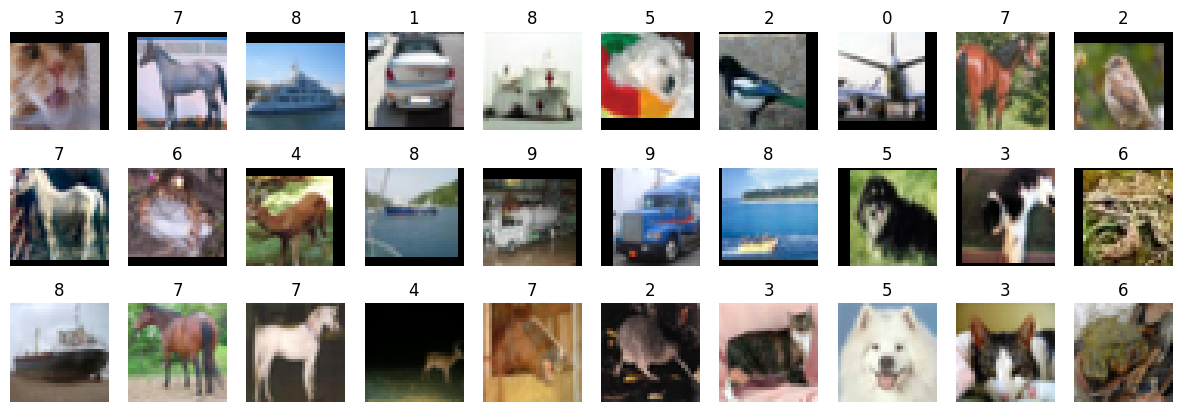

In [22]:
# Denormalization
denormalize = torchvision.transforms.v2.Compose([
    torchvision.transforms.v2.Normalize(mean = [ 0., 0., 0. ], std = 1 / std),
    torchvision.transforms.v2.Normalize(mean = -mean, std = [ 1., 1., 1. ])
])

# Display some samples from each dataset
def display_examples(dataset: torchdata.Dataset, row: int):
    train_loader = torchdata.DataLoader(dataset, batch_size = 10, shuffle = True)
    for i, (image, label) in enumerate(zip(*next(iter(train_loader)))):
        plt.subplot(3, 10, i + 10 * (row - 1) + 1)
        plt.axis('off')
        plt.title('{}'.format(label))
        plt.imshow((denormalize(image).permute(1, 2, 0).numpy() * 255).astype(numpy.uint8))

plt.rcParams["figure.figsize"] = (15, 5)
display_examples(train_set, 1)
display_examples(val_set, 2)
display_examples(test_set, 3)

# Code for training

In [23]:
class BaseClassifier(abc.ABC):
    @abc.abstractmethod
    def fit(self, train_set: torchdata.Dataset, val_set: torchdata.Dataset):
        raise NotImplementedError

    @abc.abstractmethod
    def predict(self, images: torch.Tensor) -> typing.Tuple[torch.Tensor, torch.Tensor]:
        raise NotImplementedError
    
    def calc_metrics(self, dataset: torchdata.Dataset) -> dict:
        num_classes = self.output_shape[0] if hasattr(self, 'output_shape') else len(dataset.classes)
        classes = torch.arange(num_classes)

        all_labels = torch.tensor([])
        all_predictions = torch.tensor([])
        all_scores = torch.empty((0, num_classes))
        loader = torchdata.DataLoader(dataset, batch_size = 512, shuffle = False)
        for images, labels in loader:
            predictions, scores = self.predict(images)
            all_labels = torch.cat([ all_labels, labels ])
            all_scores = torch.cat([ all_scores, scores.detach().cpu() ])
            all_predictions = torch.cat([ all_predictions, predictions.detach().cpu() ])

        return {
            'Accuracy':       sklearn.metrics.accuracy_score      (all_labels, all_predictions),
            'TOP-2 Accuracy': sklearn.metrics.top_k_accuracy_score(all_labels, all_scores, k = 2, labels = classes),
            'TOP-3 Accuracy': sklearn.metrics.top_k_accuracy_score(all_labels, all_scores, k = 3, labels = classes),
            'TOP-4 Accuracy': sklearn.metrics.top_k_accuracy_score(all_labels, all_scores, k = 4, labels = classes),
            'TOP-5 Accuracy': sklearn.metrics.top_k_accuracy_score(all_labels, all_scores, k = 5, labels = classes),
            'TOP-6 Accuracy': sklearn.metrics.top_k_accuracy_score(all_labels, all_scores, k = 6, labels = classes),
            'TOP-7 Accuracy': sklearn.metrics.top_k_accuracy_score(all_labels, all_scores, k = 7, labels = classes),
            'TOP-8 Accuracy': sklearn.metrics.top_k_accuracy_score(all_labels, all_scores, k = 8, labels = classes),
            'TOP-9 Accuracy': sklearn.metrics.top_k_accuracy_score(all_labels, all_scores, k = 9, labels = classes),
            'AUC-ROC':        sklearn.metrics.roc_auc_score       (all_labels, all_scores, multi_class = 'ovo'),
            'Precision':      sklearn.metrics.precision_score     (all_labels, all_predictions, average = 'macro', zero_division = 0),
            'Recall':         sklearn.metrics.recall_score        (all_labels, all_predictions, average = 'macro', zero_division = 0),
            'F1-score':       sklearn.metrics.f1_score            (all_labels, all_predictions, average = 'macro', zero_division = 0)
        }

In [24]:
class Classifier(BaseClassifier):
    results = [ ]

    def __init__(
            self,
            name: str,
            model: torch.nn.Module,
            batch_size: int = 256,
            learning_rate: int = 1e-3,
            device: torch.device = device,
            optimizer: typing.Optional[torch.optim.Optimizer] = None,
            scheduler: typing.Optional[torch.optim.lr_scheduler.LRScheduler] = None,
        ):
        self.name = name
        self.history = [ ]
        self.device = device
        self.input_shape = None
        self.output_shape = None
        self.scheduler = scheduler
        self.batch_size = batch_size
        self.model = model.to(self.device)
        self.optimizer = optimizer or torch.optim.AdamW(self.model.parameters(), lr = learning_rate)


    def train(self, images: torch.Tensor, labels: torch.Tensor) -> float:
        self.model.train() # Enter train mode
        self.optimizer.zero_grad() # Zero gradients
        output = self.model(images.to(self.device)) # Get predictions
        loss = torch.nn.functional.cross_entropy(output, labels.to(self.device)) # Calculate loss
        loss.backward() # Calculate gradients
        self.optimizer.step() # Update weights
        if self.scheduler is not None:
            self.scheduler.step() # Change learning rate
        return loss.item()

    def train_epoch(self, loader: torchdata.DataLoader) -> float:
        sum_loss = 0
        for images, labels in loader:
            sum_loss += self.train(images, labels) # Train one batch
        return sum_loss / len(loader) # Return average loss to avoid random-dependent graph
       
    def fit(self, train_set: torchdata.Dataset, val_set: torchdata.Dataset, n_epochs: int = 25, silent: bool = False):
        if self.input_shape is None or self.output_shape is None:
            self.predict(train_set[0][0].unsqueeze(0)) # Initialize lazy layers and in/out shapes
        loader = torchdata.DataLoader(train_set, batch_size = self.batch_size, shuffle = True)

        wandb_settings = { "silent": True, "disable_git": True } if silent else None
        wandb.init(project = "CV-HW-5", name = self.name, anonymous = "allow", settings = wandb_settings)
        wandb.watch(self.model, log = "all")

        for epoch in tqdm.trange(n_epochs, desc = "Fit {}".format(self.name)):
            # Train
            train_start = time.perf_counter()
            loss = self.train_epoch(loader)
            train_time = time.perf_counter() - train_start

            # Validate
            val_start = time.perf_counter()
            metrics = self.calc_metrics(val_set)
            val_time = time.perf_counter() - val_start
            
            # Upload metrics
            metrics['Learning rate'] = self.optimizer.param_groups[0]['lr']
            metrics['Validation time'] = val_time
            metrics['Train time'] = train_time
            metrics['Loss'] = loss
            wandb.log(metrics)
            metrics['Epoch'] = epoch + 1
            self.history.append(metrics)

        # Finish the run
        wandb.finish(quiet = True)

        # Store best metrics
        self.best_metrics = max(self.history, key = lambda item: item['Accuracy'])
        Classifier.results.append({ 'Name': self.name, **self.best_metrics })
        return self
    

    def predict(self, images: torch.Tensor) -> typing.Tuple[torch.Tensor, torch.Tensor]:
        if self.input_shape is None:
            self.input_shape = images[0].shape # Lazily initialize input shape

        self.model.eval() # Enter evaluation mode
        with torch.no_grad():
            outputs = self.model(images.to(self.device)) # Get outputs
            scores = torch.softmax(outputs, dim = 1) # Make probabilities
            predictions = torch.argmax(scores, dim = 1) # Calculate predictions

        if self.output_shape is None:
            self.output_shape = scores[0].shape # Lazily initialize output shape
        return predictions, scores
    

    def summary(self):
        display(pandas.DataFrame(Classifier.results)) # Print run history
        warnings.filterwarnings("ignore") # Ignore warnings that might be printed by torchscan.summary
        torchscan.summary(self.model.eval(), self.input_shape, receptive_field = True) # Print summary about this model

# Main task

Create your own resnet - like model with depth of 15 - 25 layers

Look at original paper before coding : https://arxiv.org/pdf/1512.03385.pdf

Don't directly use code from here: https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py

Train and test it on CIFAR10, compare results with original model

In [25]:
class BasicBlock(torch.nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()

        # If the amount of channels increases, the size of the feature map should decrease
        stride = out_channels // in_channels

        # Direct path with two 3x3 convolutions
        self.direct = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1, stride = stride), torch.nn.BatchNorm2d(out_channels), torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size = 3, padding = 1), torch.nn.BatchNorm2d(out_channels)
        )
        
        # Shortcut path
        self.shortcut = torch.nn.Identity() # By default, the shortcut is an identity mapping
        if stride != 1:
            # If the amount of channels changes, the shortcut is a 1x1 convolution 
            self.shortcut = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels, out_channels, kernel_size = 1, stride = stride),
                torch.nn.BatchNorm2d(out_channels)
            )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return torch.nn.functional.relu(self.direct(x) + self.shortcut(x))

In [26]:
def make_block(n: int, in_channels: int, out_channels: int):
    # 2n layers for each feature map size
    return torch.nn.Sequential(
        BasicBlock(in_channels, out_channels), # First 2 layers may increase the number of channels
        *[ BasicBlock(out_channels, out_channels) for _ in range(n - 1) ] # Remaining (2n - 2) layers
    )

def CustomResNet(n: int = 3) -> torch.nn.Module:
    # We ... adopt the weight initialization in [13] and BN [16] but with no dropout.
    return torch.nn.Sequential(
        # The first layer is 3×3 convolutions
        torch.nn.Sequential(
            torch.nn.Conv2d(3, 16, kernel_size = 3, padding = 1),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU()
        ),

        # Then we use a stack of 6n layers with 3×3 convolutions on the feature maps of sizes {32, 16, 8} respectively, with 2n layers for each feature map size.
        # The numbers of filters are {16, 32, 64} respectively
        make_block(n, 16, 16), # 2n layers
        make_block(n, 16, 32), # 2n layers
        make_block(n, 32, 64), # 2n layers
        
        # The network ends with a global average pooling
        torch.nn.AdaptiveAvgPool2d((1, 1)),
        # a 10-way fully-connected layer
        torch.nn.Flatten(),
        torch.nn.Linear(64, 10)
        # Softmax is applied in Classifier.predict
    )

In [27]:
fix_random()
def lr_scheduler_lambda(iteration):
    # We ... divide it [learning rate] by 10 at 32k and 48k iterations
    if iteration < 32000:
        return 1
    if iteration < 48000:
        return 0.1
    return 0.01

model = CustomResNet().to(device)

# We start with a learning rate of 0.1
# We use a weight decay of 0.0001 and momentum of 0.9
optimizer = torch.optim.SGD(model.parameters(), lr = 0.1, momentum = 0.9, weight_decay = 0.0001)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_scheduler_lambda)

# These models are trained with a minibatch size of 128 terminate training at 64k iterations
# 64k iterations is approximately 182 epochs:
#   45000 / 128 = 351.5625 => 352 iterations per epoch
#   64000 / 352 = 181.(81)
classifier = Classifier('CustomResNet', model, batch_size = 128, optimizer = optimizer, scheduler = scheduler).fit(train_set, val_set, 182)
classifier.summary()
classifier.calc_metrics(test_set)

Fit CustomResNet: 100%|██████████| 182/182 [1:06:43<00:00, 22.00s/it]


,Name,Accuracy,TOP-2 Accuracy,TOP-3 Accuracy,TOP-4 Accuracy,TOP-5 Accuracy,TOP-6 Accuracy,TOP-7 Accuracy,TOP-8 Accuracy,TOP-9 Accuracy,AUC-ROC,Precision,Recall,F1-score,Learning rate,Validation time,Train time,Loss,Epoch
0,CustomResNet,0.9168,0.9738,0.9882,0.9942,0.9978,0.999,0.9992,0.9994,1.0,0.995225,0.916775,0.916587,0.916577,0.001,1.609378,21.325906,0.018946,166


____________________________________________________________________________________________________________
Layer                        Type                  Output Shape              Param #         Receptive field
sequential                   Sequential            (-1, 10)                  0               317            
├─0                          Sequential            (-1, 16, 32, 32)          0               317            
|    └─0                     Conv2d                (-1, 16, 32, 32)          448             317            
|    └─1                     BatchNorm2d           (-1, 16, 32, 32)          65              315            
|    └─2                     ReLU                  (-1, 16, 32, 32)          0               315            
├─1                          Sequential            (-1, 16, 32, 32)          0               315            
|    └─0                     BasicBlock            (-1, 16, 32, 32)          0               315            
|    |    └─direct 

{'Accuracy': 0.9139,
 'TOP-2 Accuracy': 0.9708,
 'TOP-3 Accuracy': 0.9872,
 'TOP-4 Accuracy': 0.9936,
 'TOP-5 Accuracy': 0.997,
 'TOP-6 Accuracy': 0.9984,
 'TOP-7 Accuracy': 0.9992,
 'TOP-8 Accuracy': 0.9998,
 'TOP-9 Accuracy': 0.9999,
 'AUC-ROC': 0.9949656722222222,
 'Precision': 0.9139893227924507,
 'Recall': 0.9138999999999999,
 'F1-score': 0.913854365291747}

In [28]:
classifier.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (1): Sequential(
    (0): BasicBlock(
      (direct): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (shortcut): Identity()
    )
    (1): BasicBlock(
      (direct): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding

# Train resnet18 from torchvision.models

  Train from scratch Resnet18 on CIFAR-10
  Compare results with yours and with results from original paper:


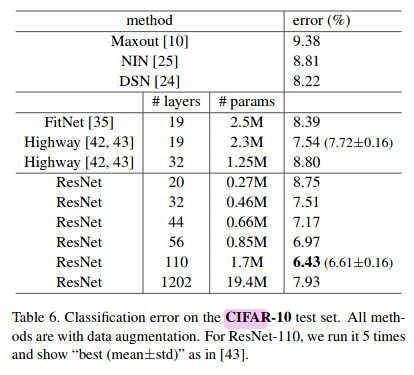

 https://arxiv.org/pdf/1512.03385.pdf

In [29]:
fix_random()

model = torchvision.models.resnet18(weights = None, num_classes = 10).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.1, momentum = 0.9, weight_decay = 0.0001)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_scheduler_lambda)
resnet18_classifier = Classifier('resnet18', model, batch_size = 128, optimizer = optimizer, scheduler = scheduler).fit(train_set, val_set, 182)
resnet18_classifier.summary()
resnet18_classifier.calc_metrics(test_set)

Fit resnet18: 100%|██████████| 182/182 [59:40<00:00, 19.67s/it]


,Name,Accuracy,TOP-2 Accuracy,TOP-3 Accuracy,TOP-4 Accuracy,TOP-5 Accuracy,TOP-6 Accuracy,TOP-7 Accuracy,TOP-8 Accuracy,TOP-9 Accuracy,AUC-ROC,Precision,Recall,F1-score,Learning rate,Validation time,Train time,Loss,Epoch
0,CustomResNet,0.9168,0.9738,0.9882,0.9942,0.9978,0.9990,0.9992,0.9994,1.0000,0.995225,0.916775,0.916587,0.916577,0.001,1.609378,21.325906,0.018946,166
1,resnet18,0.8632,0.9438,0.9702,0.9842,0.9902,0.9952,0.9976,0.9986,0.9998,0.987956,0.862616,0.862844,0.862419,0.001,1.508068,18.846575,0.036656,152


____________________________________________________________________________________________________________
Layer                        Type                  Output Shape              Param #         Receptive field
resnet                       ResNet                (-1, 10)                  0               1891           
├─conv1                      Conv2d                (-1, 64, 16, 16)          9,408           1891           
├─bn1                        BatchNorm2d           (-1, 64, 16, 16)          257             943            
├─relu                       ReLU                  (-1, 64, 16, 16)          0               943            
├─maxpool                    MaxPool2d             (-1, 64, 8, 8)            0               943            
├─layer1                     Sequential            (-1, 64, 8, 8)            0               471            
|    └─0                     BasicBlock            (-1, 64, 8, 8)            0               471            
|    |    └─conv1  

{'Accuracy': 0.8586,
 'TOP-2 Accuracy': 0.9434,
 'TOP-3 Accuracy': 0.9705,
 'TOP-4 Accuracy': 0.9834,
 'TOP-5 Accuracy': 0.9913,
 'TOP-6 Accuracy': 0.9953,
 'TOP-7 Accuracy': 0.9975,
 'TOP-8 Accuracy': 0.9988,
 'TOP-9 Accuracy': 0.9995,
 'AUC-ROC': 0.9865635333333335,
 'Precision': 0.8601107122684981,
 'Recall': 0.8586,
 'F1-score': 0.859109112543319}

# Place for conclusion:

| Модель | Accuracy (%) | Error (%) |
| - | - | - |
| Моя реализация | 91.39 | 8.61 |
| Реализация из статьи | 91.25 | 8.75 |
| resnet18 | 85.86 | 14.14 |
| Простейшая свёрточная сеть из прошлого задания | 83.52 | 16.48 |

![Alternative Text][1699801262588]

[1699801262588]: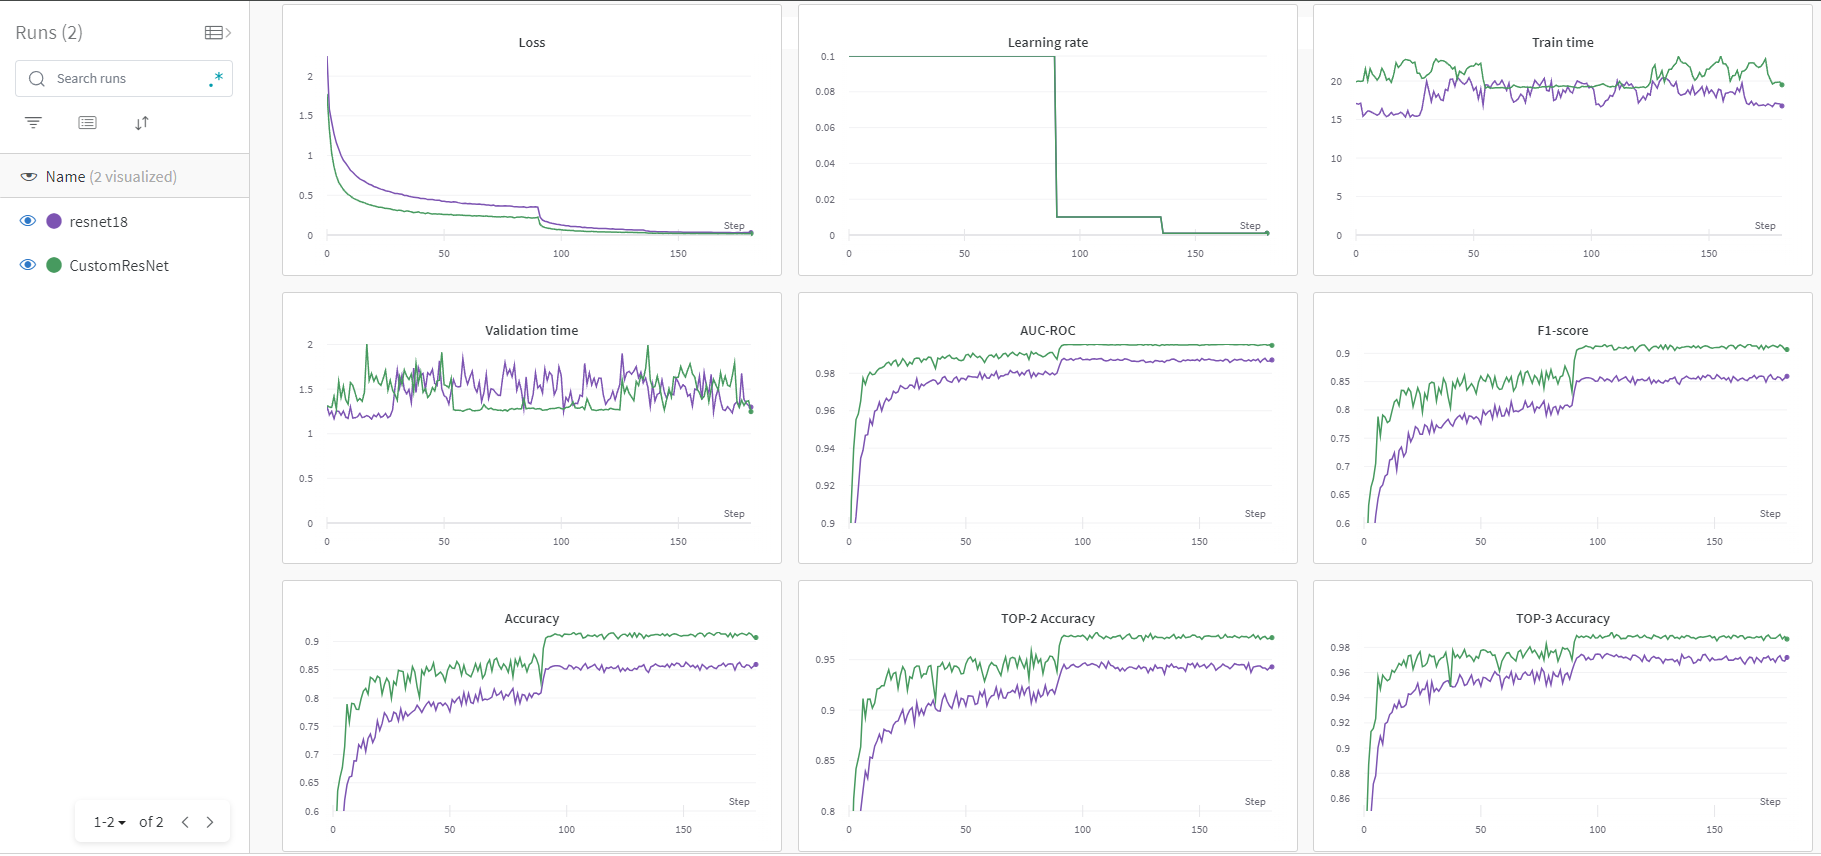